# Аналитика в Яндекс.Афише

Необходимо помочь маркетологам оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

    лог сервера с данными о посещениях сайта Яндекс.Афиши,
    выгрузка всех заказов за этот период,
    статистика рекламных расходов.

Необходимо изучить:

    как люди пользуются продуктом,
    когда они начинают покупать,
    сколько денег приносит каждый клиент
    когда клиент окупается.

## Содержание:

1. [Загрузка и предобработка данных данных\*](#1)
2. [Исследование](#2)

      1. [Продукт](#2.1)
        - [Сколько людей пользуются в день, неделю, месяц?](#2.1.1)
        - [Сколько сессий в день?](#2.1.2)
        - [Сколько длится одна сессия?](#2.1.3)
        - [Как часто люди возвращаются?](#2.1.4)

      2. [Продажи](#2.2)
        - [Когда люди начинают покупать?](#2.2.1)
        - [Сколько раз покупают за период?](#2.2.2)
        - [Какой средний чек?](#2.2.3)
        - [Сколько денег приносят? (LTV)](#2.2.4)

      3. [Маркетинг](#2.3)
        - [Сколько денег потратили? Всего / на каждый источник / по времени](#2.3.1)
        - [Сколько стоило привлечение одного покупателя из каждого источника?](#2.3.2)
        - [Насколько окупились расходы? (ROI)](#2.3.3)
3. [Общие выводы](#3)


\* *Под uid понимаем конкретного пользователя (человека)*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def checking(df):
    print(df.head())
    print()
    print(df.info())
    print()
    print('duplicated:', df.duplicated().sum())
    print()
    print(df.describe())
    print()
    print(df.hist(bins=20))

## 1. Загрузка и предобработка данных <a name="1"></a>

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

duplicated: 0

           Source Id           Uid
count  359400.000000  3.594000e+0

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
Name: Start Ts, dtype: object

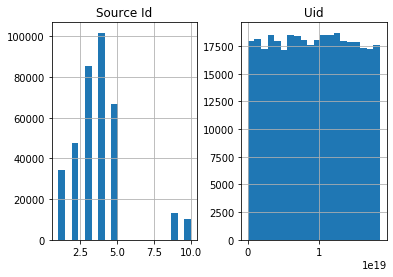

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')
print(checking(visits))
visits['Start Ts'].describe()

In [4]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [5]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['duration'] = (visits.end_ts - visits.start_ts) / np.timedelta64(1, 's')
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['date'] = visits['start_ts'].dt.date

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  duration      month       week        date  
0  16879256277535980062    1080.0 2017-12-01 2017-12-14  2017-12-20  
1    104060357244891740    1680.0 2018-02-01 2018-02-15  2018-02-19  
2   7459035603376831527       0.0 2017-07-01 2017-06-29  2017-07-01  
3  16174680259334210214    1440.0 2018-05-01 2018-05-17  2018-05-20  
4   9969694820036681168       0.0 2017-12-01 2017-12-21  2017-12-27  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns

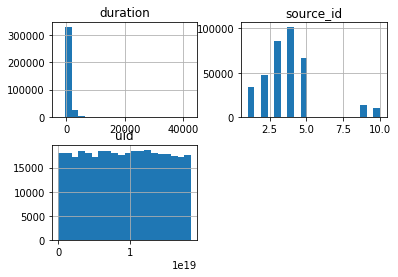

In [6]:
checking(visits)

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

duplicated: 0

            Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb609c2c110>
None


count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
Name: Buy Ts, dtype: object

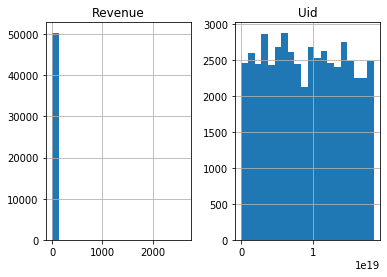

In [7]:
orders = pd.read_csv('/datasets/orders_log.csv')
print(checking(orders))
orders['Buy Ts'].describe()

In [8]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders = orders.query('buy_ts < "2018-06-01"').reset_index(drop=True)
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50414 entries, 0 to 50413
Data columns (total 4 columns):
buy_ts       50414 non-null datetime64[ns]
revenue      50414 non-null float64
uid          50414 non-null uint64
buy_month    50414 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

duplicated: 0

         source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb609c7ed50>


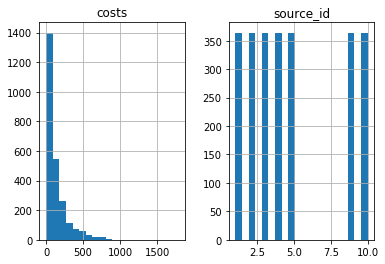

In [10]:
costs = pd.read_csv('/datasets/costs.csv')
checking(costs)

In [11]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.month = costs.month.dt.strftime('%Y-%m-%d')

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
month        2542 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 79.6+ KB


Данные загружены, проверены, приведены к нужному формату.
Исследование охватывает год работы сервиса: с 01.06.2017 по 31.05.2018

Суммы заказов распределены неравномерно, явно есть запредельно большие суммы, но сегментировать клиентов мы не будем, а изучим совокупные показатели. То же казается сессий, в продолжительности которых наблюдаются выбросы. В целом, данные корректны и потребовалось лишь изменение формата дат.
Финансирование 7 каналов привлечения пользователей различно, хотя и не сильно, 3 и 4 источники приводят больше визитов на сайт.

## 2. Исследование<a name="2"></a>
### Продукт<a name="2.1"></a>

    Сколько людей пользуются в день, неделю, месяц?
    Сколько сессий в день?
    Сколько длится одна сессия?
    Как часто люди возвращаются?

In [13]:
print('Всего пользователей:', visits['uid'].nunique())
display(pd.DataFrame(index=['dau', 'wau', 'mau'], columns=['touch', 'desktop'],
    data = ([visits.query('device==@i').groupby('date')['uid'].nunique().mean().astype('int') for i in ('touch', 'desktop')],
            [visits.query('device==@i').groupby('week')['uid'].nunique().mean().astype('int') for i in ('touch', 'desktop')],
            [visits.query('device==@i').groupby('month')['uid'].nunique().mean().astype('int') for i in ('touch', 'desktop')]
           )).join(pd.Series([visits.groupby(i)['uid'].nunique().mean().astype('int') for i in ('date', 'week', 'month')], 
                             index=['dau', 'wau', 'mau'], 
                             name='total'
                            )
                  )
     )
print('Пользователей с более, чем 1 визитом:', (visits.groupby('uid').count() > 1).sum()[0])


Всего пользователей: 228169


,touch,desktop,total
dau,252,659,907
wau,1637,4135,5724
mau,6825,16724,23228


Пользователей с более, чем 1 визитом: 52128


- За весь рассматриваемый год на сайте Афиши побывало 228169 человек.
- Средние показатели: 907 человек в день, 5724 в неделю (в 6,31 раз больше, чем за день) и 23228 в месяц (в 25,6 раз больше, чем за день). 
- Суммарное количество пользователей в разбивке по устройствам практически равно совокупному количеству уникальных посетителей.

Эти соотношения означают, что абсолютное большинство пользователей ограничилось 1 визитом, лишь 52 тыс. чел. пришли повторно.

Отобразим динамику изменения количества уникальных пользователей на графиках.

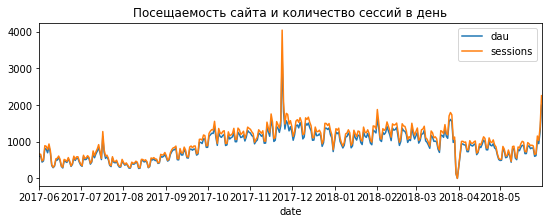

Медианное количество пользователей и сессий в день


uid          921.0
start_ts    1003.0
dtype: float64

In [14]:
visits.groupby('date').agg({'uid':'nunique', 'start_ts':'count'}).plot(figsize=(9,3))
plt.legend(labels=['dau', 'sessions'])
plt.title('Посещаемость сайта и количество сессий в день')
plt.show()
print('Медианное количество пользователей и сессий в день')
visits.groupby('date').agg({'uid':'nunique', 'start_ts':'count'}).median()

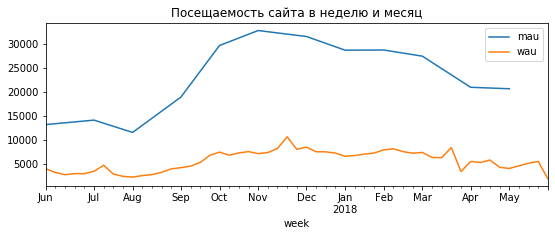

In [15]:
visits.groupby('month')['uid'].nunique().plot(figsize=(9,3))
visits.groupby('week')['uid'].nunique().plot()
plt.legend(labels=['mau', 'wau'])
plt.title('Посещаемость сайта в неделю и месяц')
plt.show()

Заметны недельные колебания посещаемости и высокий сезон с октября по апрель, к тому же на протяжении года есть 3 пиковых дня: в ноябре и в конце мая очень много визитов, в конце марта странно мало. Возможно, малое количество визитов объясняется поломкой в сборе данных, а большое - интересными событиями, но это только предположения.
Данные выбросы являются аномалиями, которые можно исследовать отдельно, но едва ли они серьезно скажутся на усредненных значениях, поэтому оставим их без корректировок. Медианными значениями являются 921 человек и 1003 сессий в день или 1,09 сессий приходится в среднем на человека в день.

**Исследуем продолжительность сессий**

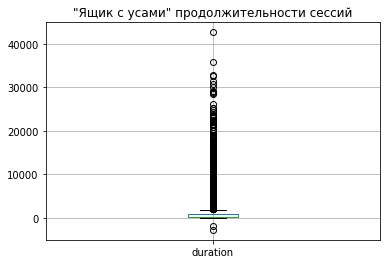

Наиболее частое значение: 60 сек.


In [16]:
plt.title('"Ящик с усами" продолжительности сессий')
visits.boxplot('duration')
plt.show()
print('Наиболее частое значение:', visits.duration.mode().astype('int')[0], 'сек.')

2 сессии с отрицательным временем похожи на ошибки, избавимся от них. Нулевая продолжительность сессий не обязательно ошибочный заход, возможно, пользователь провел на сайте какое-то время, но не выполнил фиксируемых счетчиком действий, поэтому их оставим.

In [17]:
visits = visits.query('duration >= 0').reset_index(drop=True)

In [18]:
visits.duration.describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration, dtype: float64

Большинство сессий имеют продолжительность в 1 минуту, а 50% распределены на диапазоне от 2 до 14 минут, что вполне правдоподобно для сайта Афиши. Рекорды вроде многочасового "зависания" похожи на коммерческие визиты, например, они могут принадлежать сотрудникам других агентств по продаже билетов или театральным критикам. Не исключены и технические ошибки, например, старт сессии принадлежит одному реадьному заходу, а конец - другому реальному заходу через несколько часов после первого.

Чтобы ответить на вопрос, как часто люди возвращаются, найдем **retention rate**. И для более полного представления сделаем это по месячным когортам.

In [19]:
first_visits = visits.sort_values(by='start_ts').groupby('uid').agg({'date':'min', 'source_id':'first'}).reset_index()
first_visits['date'] = first_visits['date'].astype('datetime64[1M]')
first_visits.columns=['uid', 'first_visit_month', 'first_visit_source_id']

In [20]:
visits = visits.merge(first_visits, on='uid')

In [21]:
visits['age'] = ((visits['month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')).round().astype('int')  
visits_cohorts = visits.groupby(['first_visit_month', 'age', 'month']).agg({'uid':'nunique'}).reset_index()
visits_cohorts = visits_cohorts.merge(visits_cohorts.query('age == 0')[['first_visit_month', 'uid']], on = 'first_visit_month', suffixes = ('', '_total'))
visits_cohorts['retention'] = visits_cohorts['uid'] / visits_cohorts['uid_total']

retention = visits_cohorts.pivot_table(index='first_visit_month', columns='age', values='retention', aggfunc='sum')
viz_retention = pd.DataFrame(visits.query('age == 0').groupby('first_visit_month')['uid'].nunique())\
                             .join(retention.loc[:, 1:].round(2))
viz_retention.index = viz_retention.index.strftime('%Y-%m-%d')

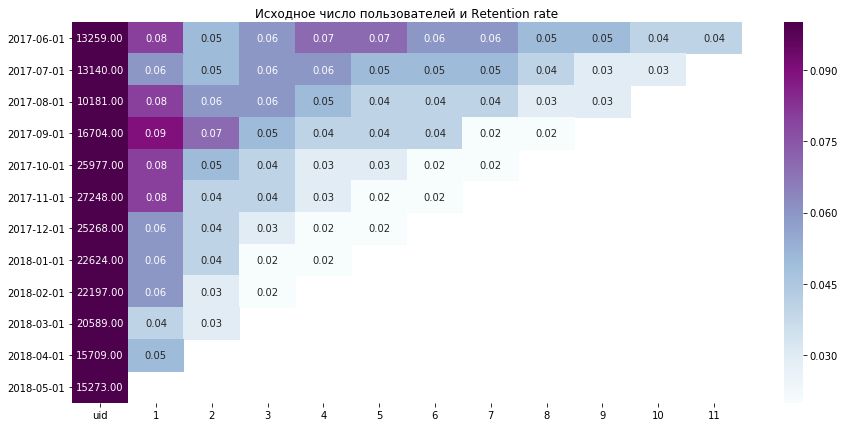

In [22]:
plt.figure(figsize=(15,7))
plt.title('Исходное число пользователей и Retention rate')
sns.heatmap(viz_retention, annot=True, fmt='.2f', cmap='BuPu', vmax=0.1 )

Первый столбец - число пользователей в когорте. Остальные столбцы расчитываются как доля от изначального количества (100%).
Рассмотрим возвращаемость отдельно по типам устройств.

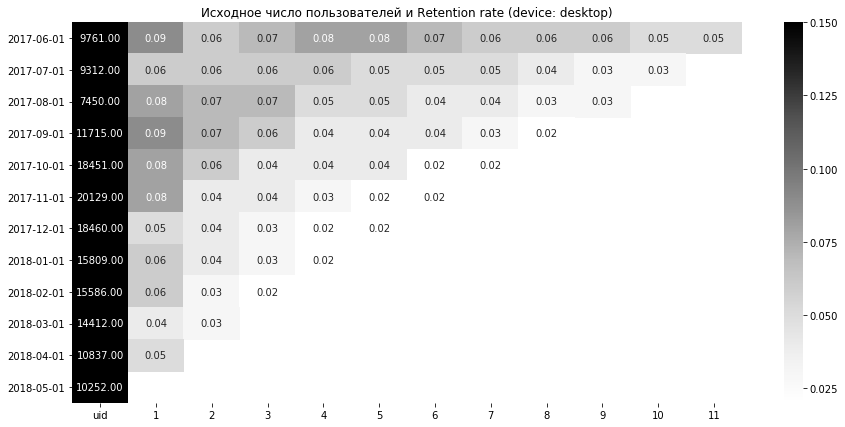

In [23]:
visits_cohorts_desktop = visits.query('device=="desktop"').groupby(['first_visit_month', 'age', 'month']).agg({'uid':'nunique'}).reset_index()
visits_cohorts_desktop = visits_cohorts_desktop.merge(visits_cohorts_desktop.query('age == 0')[['first_visit_month', 'uid']], on = 'first_visit_month', suffixes = ('', '_total'))
visits_cohorts_desktop['retention'] =  visits_cohorts_desktop['uid'] / visits_cohorts_desktop['uid_total']

retention_desktop = visits_cohorts_desktop.pivot_table(index='first_visit_month', columns='age', values='retention', aggfunc='sum')
viz_retention_desktop = pd.DataFrame(visits.query('age == 0 and device=="desktop"').groupby('first_visit_month')['uid'].nunique())\
                             .join(retention_desktop.loc[:, 1:].round(2))
viz_retention_desktop.index = viz_retention_desktop.index.strftime('%Y-%m-%d')

plt.figure(figsize=(15,7))
plt.title('Исходное число пользователей и Retention rate (device: desktop)')
sns.heatmap(viz_retention_desktop, annot=True, fmt='.2f', cmap='Greys', vmax=0.15 )

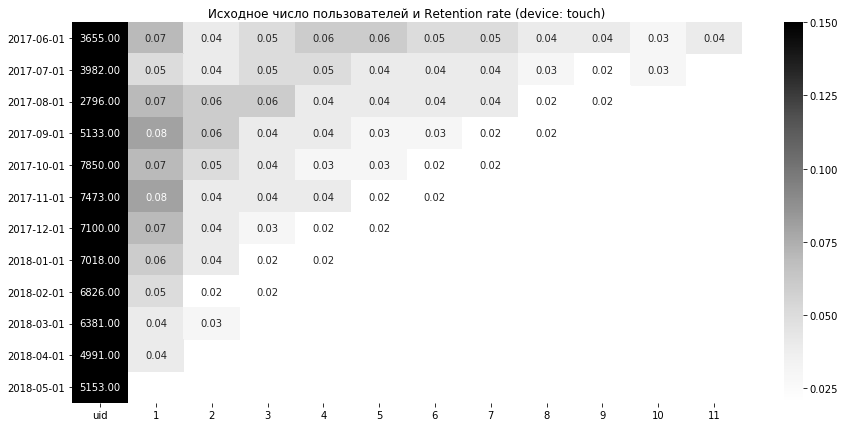

In [24]:
visits_cohorts_touch = visits.query('device=="touch"').groupby(['first_visit_month', 'age', 'month']).agg({'uid':'nunique'}).reset_index()
visits_cohorts_touch = visits_cohorts_touch.merge(visits_cohorts_touch.query('age == 0')[['first_visit_month', 'uid']], on = 'first_visit_month', suffixes = ('', '_total'))
visits_cohorts_touch['retention'] = visits_cohorts_touch['uid'] / visits_cohorts_touch['uid_total']

retention_touch = visits_cohorts_touch.pivot_table(index='first_visit_month', columns='age', values='retention', aggfunc='sum')
viz_retention_touch = pd.DataFrame(visits.query('age == 0 and device=="touch"').groupby('first_visit_month')['uid'].nunique())\
                             .join(retention_touch.loc[:, 1:].round(2))
viz_retention_touch.index = viz_retention_touch.index.strftime('%Y-%m-%d')

plt.figure(figsize=(15,7))
plt.title('Исходное число пользователей и Retention rate (device: touch)')
sns.heatmap(viz_retention_touch, annot=True, fmt='.2f', cmap='Greys', vmax=0.15 )

Летом на сайт Афиши заходит меньше новых пользователей, чем в разгар театрального сезона - осенью и зимой. Около 75% используют компьютеры для визита на сайт, и лишь четверть - переносные устройства.

Показатель возвращаемости зависит как от сезона, так и от типа устройства пользователя: 
- когорты с июня по ноябрь имеют более высокий retention rate, до 8% в следующий после первого захода месяц, который плавно снижается до 4% в январе и далее до 2% к концу театрального сезона, независимо от изначального размера когорты. Некоторый "дисбаланс" наблюдается у соседних месяцев - в июне новых пользователей немного, но у них рекордный retention даже спустя многие месяцы, в то время как июльские новички показали низкую возвращаемость в первый месяц, но затем она вырастает до средних показателей. Вероятно, это связано с "мертвым сезоном" в августе.
- пользователи, впервые посетившие сайт в зимний период, в дальнейшем пользуются им реже.
- пользователи, зашедшие на сайт с мобильных устройств, показывают несколько меньшую возвращаемость чем те, кто использовал компьютер.

### Продажи <a name="2.2"></a>

    Когда люди начинают покупать?
    Сколько раз покупают за период?
    Какой средний чек?
    Сколько денег приносят? (LTV)

Дни до первой покупки, чел


0      26394
1       2588
2       1027
3        660
4        592
       ...  
360        1
361        1
362        2
363        9
364        4
Length: 365, dtype: int64

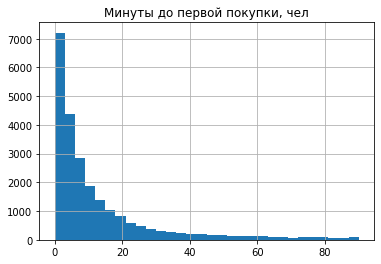

In [25]:
orders = orders.join(visits.groupby('uid')['start_ts'].min(), on='uid')
plt.title('Минуты до первой покупки, чел')
((orders['buy_ts'] - orders['start_ts']) / np.timedelta64(1, 'm')).astype('int').hist(bins=30, range=(0, 90))
print('Дни до первой покупки, чел')
((orders['buy_ts'].dt.date - orders['start_ts'].dt.date) / np.timedelta64(1, 'D')).astype('int').value_counts().sort_index()

Из 228169 уникальных посетителей сайта 50414 делали заказы. Абсолютное большинство покупателей (52%) конвертировались в тот же день, когда впервые зашли на сайт, и почти все из них - в первые минуты сессии, остальные распределились "длинным хвостом" от 1 до 364 дней.

Оценим, как часто покупатели покупают.

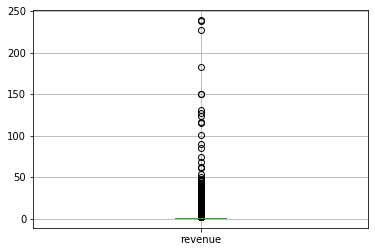

In [26]:
orders.groupby('uid').count().boxplot('revenue') 

Мы уже знаем, что большинство зарегистрированных пользователей лишь 1 раз посещает сайт Афиши, и из тех, кто делает покупки, большинство выполняет эту задачу в первые же минуты после открытия страницы, но после этого они не возвращаются на сайт и ничего не покупают. Хотя отдельные пользователи делают заказы и 100, и 200 раз за год. 

Возможно, за первую покупку с аккаунта полагалась скидка, и разные аккаунты принадлежат одним и тем же людям, но не исключен и более пессимистичный сценарий: пользователям сервис не нравится, поэтому они в самом деле редко возвращаются и редко покупают, за исключением небольшой лояльной аудитории.

Что касается десятков и сотен заказов с одной учетной записи, то это похоже на деятельность экскурсионных бюро или других коммерческих партнеров сайта и посредников.

Обычный человек, а таких большинство среди клиентов Афиши, ходит на мероприятия лишь время от времени, поэтому количество покупок и средний чек оценим в динамике по месяцам, не принимая в расчет, принадлежит ли заказ лояльному пользователю, тем более, что их всего 20%, или разовому.

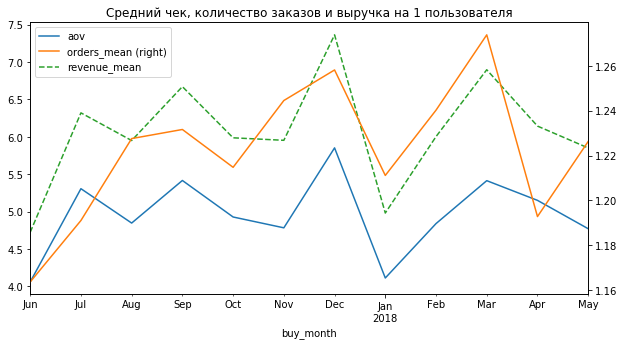

,n_uid,revenue,orders_total,aov,orders_mean,revenue_mean
buy_month,,,,,,
2017-06-01,2023,9557.49,2354,4.060106,1.163618,4.724414
2017-07-01,1984,12539.47,2363,5.306589,1.191028,6.320297
2017-08-01,1472,8758.78,1807,4.847139,1.227582,5.950258
2017-09-01,2750,18345.51,3387,5.416448,1.231636,6.671095
2017-10-01,4675,27987.70,5679,4.928280,1.214759,5.986674
2017-11-01,4547,27069.93,5659,4.783518,1.244557,5.953360
2017-12-01,4942,36388.60,6218,5.852139,1.258195,7.363132
2018-01-01,3898,19417.13,4721,4.112927,1.211134,4.981306
2018-02-01,4258,25560.54,5281,4.840095,1.240254,6.002945


In [74]:
orders_by_month = orders.groupby('buy_month').agg({'uid':'nunique', 'revenue':['sum','count']  })
orders_by_month['aov'] = orders_by_month['revenue']['sum'] / orders_by_month['revenue']['count']
orders_by_month.columns=['n_uid', 'revenue', 'orders_total', 'aov']
orders_by_month['orders_mean'] = orders_by_month['orders_total'] / orders_by_month['n_uid']
orders_by_month['revenue_mean'] = orders_by_month['revenue'] / orders_by_month['n_uid']

ax=orders_by_month['aov'].plot(legend=True)
orders_by_month['orders_mean'].plot(figsize=(10, 5), ax=ax, secondary_y=True, legend=True)
orders_by_month['revenue_mean'].plot(style='--', ax=ax, legend=True)
plt.title('Средний чек, количество заказов и выручка от 1 пользователя')
plt.show()

orders_by_month

Как и само посещение сайта, подчиненное "театральным сезонам", количество заказов (orders_total) вырастает в период с середины осени до конца весны. Особенно выделяется декабрь, в этом месяце растет так же и средний чек (aov) и средняя выручка от 1 покупателя (revenue_mean). Но происходит это благодаря новой аудитории, а не возвращаемости, т.к. количество покупок на 1 человека (orders_mean) остается примерно одинаковым на протяжении всего года. Декабрь отличается не только числом заказов, но и средним чеком, который заметно выше, чем в любой другой месяц. А в январе затем следует падение всех метрик.

**LTV** покупателей, как и возвращаемость, оценим по когортам. Для удобства дальнейшего анализа каналов привлечения покупателей сразу внесем в таблицу все нужные данные, хотя это сделает более громоздкими текущие расчеты.

In [28]:
orders = orders.merge(first_visits[['uid', 'first_visit_source_id']], on='uid')

first_orders = orders.groupby('uid')['buy_month'].min()
first_orders.name = 'first_buy_month'
orders = orders.join(first_orders, on = 'uid')
orders['age'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [29]:
orders_cohorts = orders.groupby(['first_buy_month', 'first_visit_source_id', 'age']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_cohorts = orders_cohorts.merge(orders_cohorts.query('age==0')[['first_buy_month', 'first_visit_source_id', 'uid']], on=['first_buy_month', 'first_visit_source_id'], suffixes=('', '_total'))   
orders_cohorts.first_buy_month = orders_cohorts.first_buy_month.dt.strftime('%Y-%m-%d')
ltv = (orders_cohorts.pivot_table(index='first_buy_month', columns='age', values='revenue', aggfunc='sum') / 
       orders_cohorts.pivot_table(index='first_buy_month', columns='age', values='uid_total', aggfunc='sum'))

ltv['ltv'] = ltv.sum(axis=1)
ltv.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11,ltv
first_buy_month,,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.46,1,1.07,0.77,1,0.61,0.55,0.64,0.6,0.28,12.19
2017-07-01,6.01,0.34,0.64,0.36,0.18,0.16,0.12,0.15,0.16,0.15,0.16,,8.43
2017-08-01,5.28,0.47,0.46,0.4,0.51,0.29,0.22,0.41,0.3,0.19,,,8.52
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.67,0.73,0.24,0.18,,,,13.48
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,,6.36
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,,6.40
2017-12-01,4.74,0.26,0.94,1.09,0.32,0.34,,,,,,,7.69
2018-01-01,4.14,0.29,0.3,0.15,0.06,,,,,,,,4.95
2018-02-01,4.16,0.28,0.08,0.08,,,,,,,,,4.59


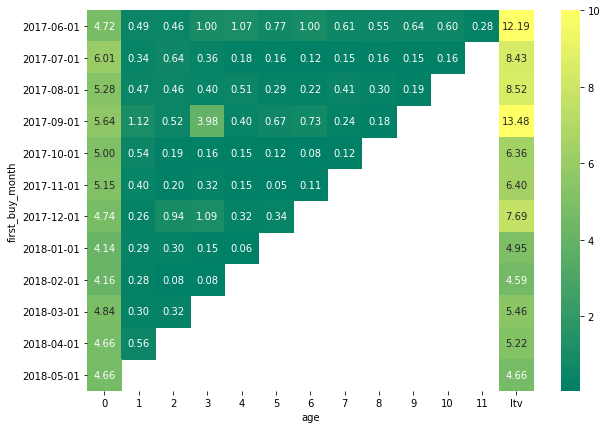

In [89]:
plt.figure(figsize=(10,7))
sns.heatmap(ltv, annot=True, fmt='.2f', cmap='summer', vmax=10)

LTV показывает, сколько в среднем 1 новый покупатель принес денег за все время пользования продуктом.

Июньскую когорту можно считать самой плодотворной, у нее более высокие показатели не только возвращаемости, но и среднего чека. 

В сентябре у нас появился пользователь (возможно, несколько), который сделал рекордные заказы под Новый год, чем и обеспечил успех всей когорты. Возможно, высокие показатели когорты в октябре, феврале и марте тоже его заслуга. Имеет смысл это исследовать и узнать, что это за пользователь и как он нас нашел, чтобы попытаться привлечь других выгодных клиентов.

Для новичков декабря февраль и март тоже стали временем дорогих заказов, но вряд ли это связано с конкретными мероприятиями, т.к. среди других пользователей таких всплесков активности не наблюдается. 

### Маркетинг

    Сколько денег потратили? Всего / на каждый источник / по времени
    Сколько стоило привлечение одного покупателя из каждого источника?
    Насколько окупились расходы? (ROI)

Всего потрачено на привлечение покупателей 329131.62


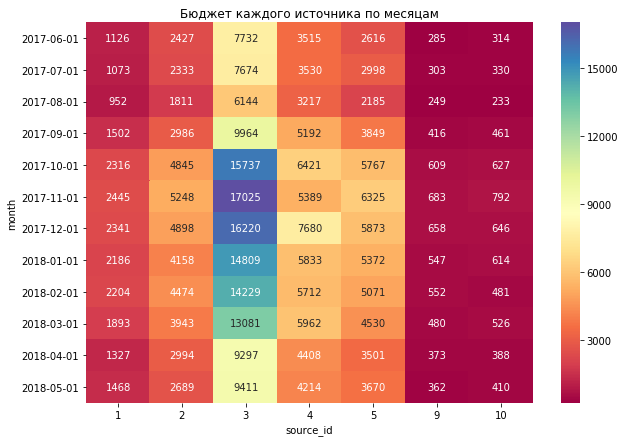

In [31]:
print('Всего потрачено на привлечение покупателей', costs.costs.sum())
costs_grouped = costs.groupby(['month', 'source_id']).costs.sum().reset_index()
costs_pivot = costs_grouped.pivot_table(index='month', columns='source_id', values='costs')
plt.figure(figsize=(10,7))
plt.title('Бюджет каждого источника по месяцам')
sns.heatmap(costs_pivot, annot=True, fmt='.0f', cmap='Spectral')
plt.show()

На 3 источник выделялись наибольшие средства, особенно в высокий сезон с октября по март, а на 9 и 10 источник больших надежд маркетологи не возлагают. Но "потраченный бюджет" - еще не значит "привлеченные покупатели". Оценим CAC - итоговую стоимость клиента.

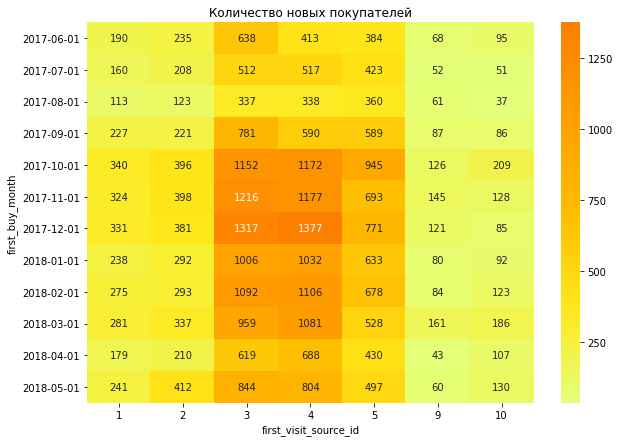

In [32]:
orders_grouped = orders_cohorts.query('age==0').groupby(['first_buy_month', 'first_visit_source_id']).uid.mean().reset_index() 
orders_pivot = orders_grouped.pivot_table(index='first_buy_month', columns='first_visit_source_id', values='uid')[[1, 2, 3, 4, 5, 9, 10]]
plt.figure(figsize=(10,7))
plt.title('Количество новых покупателей')
sns.heatmap(orders_pivot, annot=True, fmt='.0f', cmap='Wistia')
plt.show()

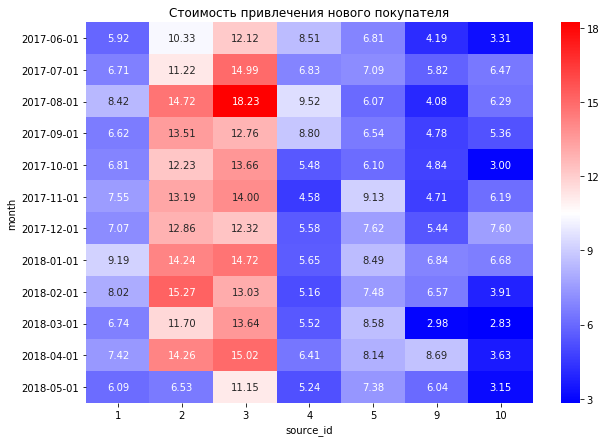

In [33]:
cac = costs_grouped.merge(orders_grouped, left_on=['month', 'source_id'], right_on=['first_buy_month', 'first_visit_source_id'])[['month', 'source_id', 'costs', 'uid']]
cac['cac'] = cac.costs / cac.uid
cac_pivot = cac.pivot_table(index='month', columns='source_id', values='cac')
plt.figure(figsize=(10,7))
plt.title('Стоимость привлечения нового покупателя')
sns.heatmap(cac_pivot, annot=True, fmt='.2f', cmap='bwr')
plt.show()

Из 3 канала приходит много покупателей, но они дорогие. 4 и 5 тоже хорошо отрабатывают и обходятся ощутимо дешевле.  Источники 1 и 2 среднепродуктивны, при этом стоимость покупателя из 2 канала получается обычно такой же, как и из 3. 

Стоит обратить внимание на взаимодействие с каналами 9 и 10. САС в них низкий, и, если их потенциал не исчерпан, это многообещающее направление вложения маркетингового бюджета.

Не все покупатели одинаково прибыльны для компании, ведь у них может быть разное количество заказов и средний чек. 
Оценим, насколько окупились расходы, т.е. показатель **ROI** - соотношение "пожизненной ценности" покупателя (LTV) к стоимости его привлечения (CAC).

In [34]:
ltv_source = {}
for i in costs.source_id.unique():
    ltv_source[i] = (orders_cohorts.query('first_visit_source_id == @i')
                   .groupby(['first_buy_month', 'age'])['revenue'].sum() / 
               orders_cohorts.query('first_visit_source_id == @i')
                   .groupby(['first_buy_month', 'age'])['uid_total'].sum())
    ltv_source[i].name = 'ltv'
    ltv_source[i] = ltv_source[i].reset_index()

In [35]:
romi = {}
for i in ltv_source.keys():
    romi[i] = ltv_source[i].merge(cac.query('source_id == @i'), left_on='first_buy_month', right_on='month')[['source_id', 'month', 'age', 'ltv', 'cac' ]]
    romi[i]['roi'] = romi[i]['ltv'] / romi[i]['cac']

In [36]:
romi_cumsum = {}
for i in romi.keys():
    romi_cumsum[i] = romi[i].pivot_table(index='month', columns='age', values='roi').cumsum(axis=1).round(1)

In [37]:
for i in romi_cumsum.keys():
    print('ROI для рекламного канала', i)
    display(romi_cumsum[i].fillna(''))
    print()

ROI для рекламного канала 1


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,1.2,1.6,2,2.6,3.3,3.7,4.1,4.5,4.9,5.2,5.4,5.7
2017-07-01,1.1,1.3,2,2.3,2.4,2.5,2.6,2.7,2.8,3,3.1,
2017-08-01,0.9,1,1.2,1.3,1.4,1.5,1.5,1.9,2.1,2.2,,
2017-09-01,0.9,1.2,1.3,1.4,1.4,1.4,1.4,1.5,1.6,,,
2017-10-01,0.9,1,1.1,1.1,1.1,1.2,1.2,1.2,,,,
2017-11-01,1.0,1.1,1.2,1.3,1.3,1.3,1.3,,,,,
2017-12-01,0.6,0.7,0.7,0.8,0.8,0.8,,,,,,
2018-01-01,0.6,0.6,0.7,0.8,0.8,,,,,,,
2018-02-01,0.6,0.7,0.7,0.8,,,,,,,,



ROI для рекламного канала 2


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,0.4,0.5,0.5,0.7,0.9,0.9,1.1,1.2,1.4,1.4,1.6,1.6
2017-07-01,0.8,0.8,0.8,0.9,0.9,0.9,0.9,0.9,1,1,1,
2017-08-01,0.4,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.6,0.6,,
2017-09-01,0.6,1.2,1.4,1.5,1.6,1.6,1.9,1.9,2,,,
2017-10-01,0.6,0.8,0.9,0.9,1,1,1,1,,,,
2017-11-01,0.5,0.6,0.6,0.7,0.7,0.7,0.7,,,,,
2017-12-01,0.7,0.8,1.5,2.4,2.6,2.9,,,,,,
2018-01-01,0.3,0.4,0.5,0.5,0.5,,,,,,,
2018-02-01,0.4,0.4,0.4,0.4,,,,,,,,



ROI для рекламного канала 3


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,0.4,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.5,0.5
2017-07-01,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,
2017-08-01,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,,
2017-09-01,0.4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,,,
2017-10-01,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,,,,
2017-11-01,0.3,0.3,0.3,0.3,0.4,0.4,0.4,,,,,
2017-12-01,0.3,0.4,0.4,0.4,0.4,0.4,,,,,,
2018-01-01,0.3,0.3,0.3,0.3,0.3,,,,,,,
2018-02-01,0.3,0.3,0.3,0.3,,,,,,,,



ROI для рекламного канала 4


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,0.6,0.6,0.6,0.6,0.8,0.9,1.1,1.1,1.2,1.3,1.4,1.4
2017-07-01,0.8,0.8,0.8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,
2017-08-01,0.5,0.5,0.6,0.6,0.6,0.6,0.6,0.7,0.7,0.7,,
2017-09-01,0.5,0.6,0.6,0.7,0.7,0.7,0.8,0.9,0.9,,,
2017-10-01,0.8,0.8,0.9,0.9,0.9,0.9,0.9,0.9,,,,
2017-11-01,1.1,1.3,1.3,1.4,1.4,1.4,1.5,,,,,
2017-12-01,0.7,0.8,0.8,0.8,0.8,0.8,,,,,,
2018-01-01,0.7,0.7,0.7,0.7,0.7,,,,,,,
2018-02-01,0.8,0.8,0.8,0.8,,,,,,,,



ROI для рекламного канала 5


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,0.7,0.9,0.9,1.1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.7
2017-07-01,0.7,0.8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,1,
2017-08-01,0.8,1,1.1,1.2,1.4,1.5,1.5,1.6,1.6,1.7,,
2017-09-01,0.9,1,1,3.5,3.6,3.9,4,4,4,,,
2017-10-01,0.8,0.9,0.9,0.9,0.9,0.9,1,1,,,,
2017-11-01,0.5,0.5,0.5,0.5,0.6,0.6,0.6,,,,,
2017-12-01,0.7,0.7,0.7,0.7,0.7,0.7,,,,,,
2018-01-01,0.5,0.6,0.6,0.6,0.6,,,,,,,
2018-02-01,0.6,0.6,0.6,0.6,,,,,,,,



ROI для рекламного канала 9


age,0,1,2,3,4,5,6,7,8,9,10
month,,,,,,,,,,,
2017-06-01,0.9,0.9,1,1.2,1.2,1.3,1.4,1.5,1.6,1.6,1.7
2017-07-01,0.8,0.8,0.9,1,1,1.1,1.1,1.1,1.2,1.2,1.2
2017-08-01,1.0,1,1.2,1.3,1.3,1.3,1.3,1.4,1.4,1.5,
2017-09-01,0.9,1.1,1.2,1.4,1.5,1.6,1.7,1.8,2,,
2017-10-01,1.0,1.2,1.2,1.3,1.3,1.4,1.4,1.5,,,
2017-11-01,0.8,0.8,0.9,0.9,0.9,1,1,,,,
2017-12-01,0.7,0.8,0.8,0.8,0.8,0.9,,,,,
2018-01-01,0.4,0.4,0.5,0.5,0.5,,,,,,
2018-02-01,0.7,0.8,0.8,,,,,,,,



ROI для рекламного канала 10


age,0,1,2,3,4,5,6,7,8,9
month,,,,,,,,,,
2017-06-01,0.7,0.8,,,,,,,0.8,
2017-07-01,0.5,0.5,,0.6,,,,,0.6,
2017-08-01,0.8,0.8,0.9,,,,,0.9,,0.9
2017-09-01,0.4,0.4,0.4,0.5,0.5,,,0.5,0.5,
2017-10-01,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,,
2017-11-01,0.7,0.8,0.8,0.8,0.8,0.8,0.8,,,
2017-12-01,0.5,0.5,,,,0.5,,,,
2018-01-01,0.5,0.5,0.5,,,,,,,
2018-02-01,0.6,0.7,0.7,,,,,,,


ROI - отличный показатель для корректировки маркетингового бюджета, как в целом, так и в части перераспределения средств между разными каналами привлечения пользователей.

Так, самый затратный 3 канал хотя и приводит к нам наибольшее количество покупателей, но не окупается даже за год ни в одной из когорт. Почти так же обстоят дела и у 2 и 4 каналов, тоже достаточно массовых, но недостаточно выгодных.

Наилучшим решением будет перераспределение средств в пользу 1 канала, который пока что получает среднее финансирование, но приводит цедрых клиентов, и совершенно недооцененный 9 канал, пользователи которого окупают себя уже на 2 месяц в наилуший сезон и за полугода в остальные периоды. 

5 канал, очевидно, принес нам самого богатого клиента, возможно, стоит там же поискать его "близнецов". 

10 канал настолько малочислен на данный момент, что убедительных выводов сделать по нему нельзя, но имеет смысл приглядеться к нему и попробовать "раскрутить".

## 3. Общие выводы

Мы исследовали основные бизнес-показатели билетного агрегатора - сайта "Яндекс.Афиша".

Каждый шестой пользователь делал заказ, типичный сценарий - это быстрая первая покупка в начале сессии и полное исчезновение посетителя, больше он на сайт не возвращается. 50% сессий длятся от 2 до 14 минут, сессии отдельных пользователей достигают нескольких часов, немало и отказов - либо это заходы по ошибке, либо просмотр 1 страницы без совершения дополнительных действий.

Вторая сессия регистрируется лишь у 20% пользователей, при этом с отдельных аккаунтов заходят десятки и даже сотни раз в год. Взаимосвязь количества и продолжительности сессий у 1 пользователя не изучалась. Предположительно, длительные заходы 
принадлежат коммерческим партнерам, экскурсионным бюро или перекупщикам билетов.

В когортном анализе по месяцам retention rate не превышает 8-9% на второй месяц и постепенно снижается до 2% с течением времени и при приближении лета - театральных каникул. Пользователи, впервые посетившие сайт в зимний период, в дальнейшем пользуются им реже. Наиболее эффективное время для рекламы Афиши - осень, пришедшие тогда пользователи показывают более высокую возвращаемость, и декабрь становится самым продуктивным временем: под Новый год вырастает не только количество заказов, но и средний чек (с 4-5 у.е. до почти 6). 



В целом, на сайте Афиши большая "текучка", и при таком положении дел, какой бы ни была большой выручка, значительная ее часть уходит на привлечение новых пользователей, которые далеко не всегда себя окупают заказами билетов. Если именно это основной источник дохода сайта, а не показ рекламы, то необходимо перераспределить маркетинговый бюджет, чтобы не нести убытки.

Исследование ltv клиентов в разбивке по рекламным каналам показывает, что наиболее мощный поток клиентов идет из 3 канала, но на него тратитися и самый большой бюджет, в итоге он не окупается даже за год. Почти так же обстоят дела и у 2 и 4 каналов, тоже достаточно массовых, но недостаточно прибыльных.

Стоит обратить внимание на возможность увеличения финансирования 1 канала, который приводит щедрых клиентов, и совершенно недооцененного 9 канала, пользователи из которого начинают приносить прибыль уже на 2 месяц в наилуший сезон и за полгода в остальные периоды.

5 канал отметился тем, что принес нам самого богатого клиента, определившего хорошие показатели всей своей когорты. Возможно, на этом его потенциал не исчерпан.

В целом, увеличение количества новых пользователей представляется не основной задачей на данный момент, и может даже принести вред, если они разочаруются агрегатором и больше не вернутся. Исходя из полученных результатов, можно сделать вывод о том, что у сервиса есть небольшое количество лояльных участников или партнеров-перекупщиков, которые генерируют львиную долю прибыли, а остальных пользователей что-то не устраивает, и сайт или сама организация агрегатора требует серьезных улучшений либо пересмотра стратегии и фокусировке на лояльных клиентах с отказом от привлечения массового покупателя по не оправдывающей себя стоимости.